In [1]:
from polygon_lake_loader import load_polygonio_lake

In [2]:
tickers = ['AAPL', 'INTC', 'TTD']

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

In [4]:
data_path = Path("~/data/polygonio_data/parquet_lake/minute_aggs_v1/spx_ndx_adjusted_full").expanduser()

In [5]:
df = load_polygonio_lake(
    tickers, 
    '2020-01-01', 
    '2025-08-15',
    data_path,
    to_timezone='UTC',
    granularity='minute',
    show_progress=True,
    workers=40,
    set_index=True,
    index_multi=True
)

Loading Parquet: 100%|██████████| 4521/4521 [00:06<00:00, 666.25file/s]


In [6]:
df

id       close  volume  \
ticker datetime                                                      
AAPL   2020-01-02 09:00:00+00:00  BBG000B9XRY4  295.079987    8910   
       2020-01-02 09:06:00+00:00  BBG000B9XRY4  295.589996     719   
       2020-01-02 09:08:00+00:00  BBG000B9XRY4  295.549988     266   
       2020-01-02 09:09:00+00:00  BBG000B9XRY4  295.750000    1410   
       2020-01-02 09:10:00+00:00  BBG000B9XRY4  295.600006    1000   
...                                        ...         ...     ...   
TTD    2025-08-13 23:55:00+00:00  BBG00629NGT2   54.310001     270   
       2025-08-13 23:56:00+00:00  BBG00629NGT2   54.299999     672   
       2025-08-13 23:57:00+00:00  BBG00629NGT2   54.328400     879   
       2025-08-13 23:58:00+00:00  BBG00629NGT2   54.320000     910   
       2025-08-13 23:59:00+00:00  BBG00629NGT2   54.299999     269   

                                  close_split  volume_split   close_tr  
ticker datetime                                                         
AAPL   2020-01-02 09:00:00+00:00    73.769997       35640.0  77.953079  
       2020-01-02 09:06:00+00:00    73.897499        2876.0  78.087814  
       2020-01-02 09:08:00+00:00    73.887497        1064.0  78.077240  
       2020-01-02 09:09:00+00:00    73.937500        5640.0  78.130081  
       2020-01-02 09:10:00+00:00    73.900002        4000.0  78.090454  
...                                       ...           ...        ...  
TTD    2025-08-13 23:55:00+00:00    54.310001         270.0  54.310001  
       2025-08-13 23:56:00+00:00    54.299999         672.0  54.299999  
       2025-08-13 23:57:00+00:00    54.328400         879.0  54.328400  
       2025-08-13 23:58:00+00:00    54.320000         910.0  54.320000  
       2025-08-13 23:59:00+00:00    54.299999         269.0  54.299999  

[2635185 rows x 6 columns]

In [14]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _spans_from_bool(mask: pd.Series):
    """Yield (start, end) timestamps where mask is True (contiguous runs)."""
    m = mask.astype(bool).astype(int)
    dm = m.diff().fillna(0)
    starts = list(mask.index[dm == 1])
    ends   = list(mask.index[dm == -1])
    # If we start in a True run, prepend the first index
    if m.iloc[0] == 1:
        starts = [mask.index[0]] + starts
    # If we end in a True run, append the last index
    if len(ends) < len(starts):
        ends = ends + [mask.index[-1]]
    return zip(starts, ends)

def plot_single_price_with_shading(
    price: pd.Series | pd.DataFrame,
    *,
    price_col: str | None = None,
    label: str | None = None,
    normalize: bool = True, base_value: float = 100.0,
    shade_positions: bool = True,
    shade_mask: pd.Series | None = None,   # optional: boolean mask to shade
    shade_color: str = "0.85", shade_alpha: float = 0.25,
):
    """
    Plot a single price series with optional normalization and shaded spans.

    Parameters
    ----------
    price : Series or DataFrame
        If Series, its index should be a DatetimeIndex. If DataFrame, provide `price_col`.
    price_col : str or None
        Column name to use when `price` is a DataFrame.
    label : str or None
        Legend label. If None and `price` is a Series with a name, that name is used.
    normalize : bool
        If True, rebase the series to `base_value` at the first point.
    base_value : float
        Base value for normalization.
    shade_positions : bool
        If True and `shade_mask` is provided, shade contiguous True spans.
    shade_mask : pd.Series or None
        Boolean Series aligned to the price index indicating periods to shade.
    shade_color, shade_alpha : str, float
        Matplotlib color and alpha for shaded regions.

    Returns
    -------
    (fig, ax)
    """
    # --- extract series ---
    if isinstance(price, pd.DataFrame):
        if price_col is None:
            # pick the first numeric column if not specified
            num_cols = [c for c in price.columns if pd.api.types.is_numeric_dtype(price[c])]
            if not num_cols:
                raise ValueError("No numeric columns found; please specify `price_col`.")
            price_col = num_cols[0]
        ser = price[price_col].copy()
        if label is None:
            label = price_col
    else:
        ser = price.copy()
        if label is None:
            label = ser.name if ser.name is not None else "Price"

    # ensure datetime index & drop NaNs
    if not isinstance(ser.index, pd.DatetimeIndex):
        raise TypeError("`price` must have a DatetimeIndex.")
    ser = ser.dropna()

    # --- normalization ---
    if normalize:
        ser_plot = ser / ser.iloc[0] * base_value
        ylab = f"Price (base={base_value:.0f})"
    else:
        ser_plot = ser
        ylab = "Price"

    # --- figure (keep size/aspect like the original: 13 x 8) ---
    fig, ax = plt.subplots(1, 1, figsize=(13, 8))

    # --- optional shading ---
    if shade_positions and shade_mask is not None:
        # align mask to series index
        mask = pd.Series(False, index=ser.index)
        mask.loc[ser.index.intersection(shade_mask.index)] = shade_mask.reindex(ser.index).fillna(False).astype(bool)
        for start, end in _spans_from_bool(mask):
            ax.axvspan(start, end, color=shade_color, alpha=shade_alpha, zorder=0)

    # --- plot line ---
    ax.plot(ser_plot.index, ser_plot.values, linewidth=1.2, label=label, zorder=2)
    ax.set_ylabel(ylab)
    ax.set_title(f"{label} — Single-Asset Price Series")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax


In [15]:
prices = df.loc[('AAPL',), 'close_tr']

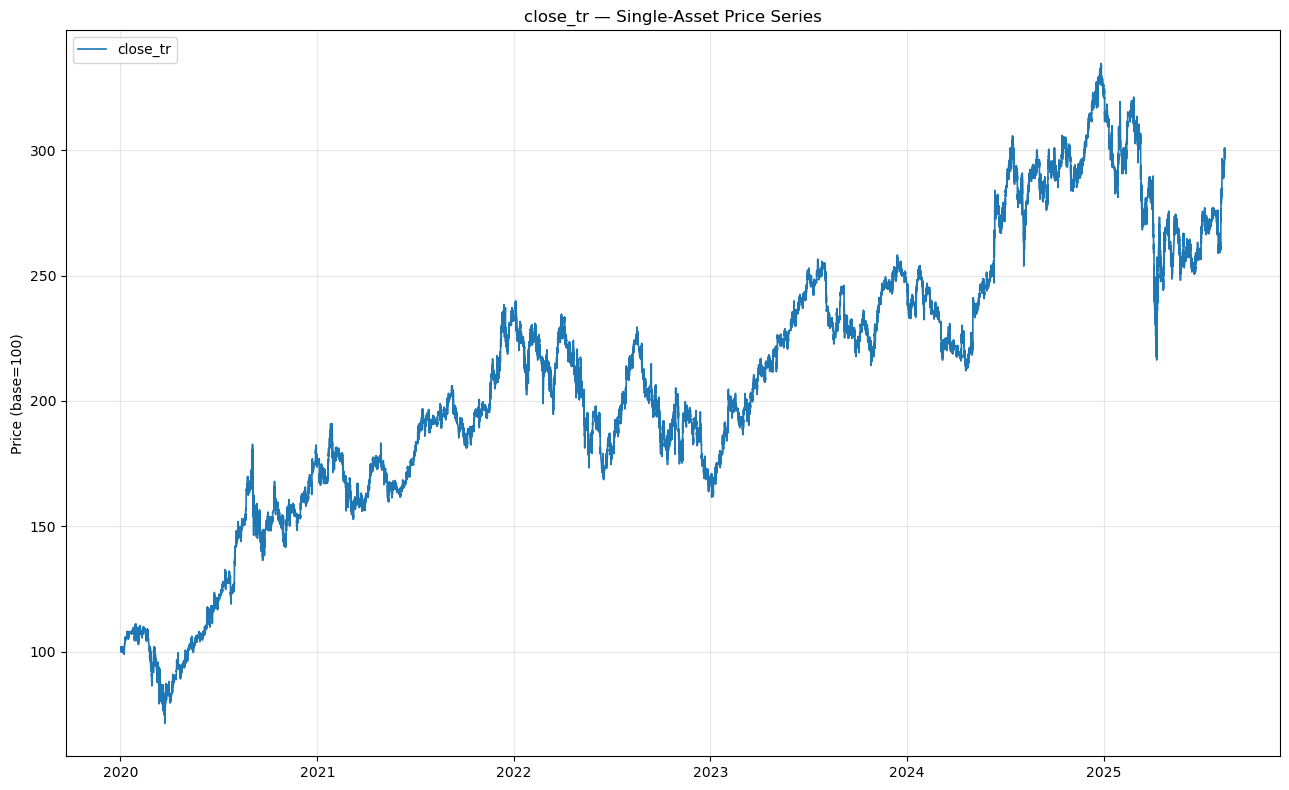

In [16]:
# If you already have `signals` with a 'pos' column:
fig, ax = plot_single_price_with_shading(prices, price_col="close_tr", normalize=True)